In [2]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
#import mplleaflet as mpll
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask


In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/geo5/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['show', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
from pandana.loaders import osm;

# Flood analysis using POIs
How does connectivity of Kampala firms with business amenities change with flooding?

In [4]:
gostNetsFolder = os.path.dirname(os.getcwd())
sys.path.insert(0, gostNetsFolder)

import GOSTnet as gn

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


In [5]:
# Data 
path = 'data'
tif = '50yrflood_Kampala.tif'
tif_path = os.path.join(path, tif)


#### 1. Import Kampala bounds and flood raster

In [6]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,32.668022,0.408476,0.21705,32.509629,"POLYGON ((32.5096294 0.3100581, 32.5097488 0.3...","Kampala, Central Region, Uganda"


In [7]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [8]:
raster = rasterio.open(tif_path)

In [9]:
ax = boundary_GDF.plot(figsize=[6,6],alpha = 0.5)
show(raster, ax = ax)
plt.title('Kampala inner city boundary vs. flood map');

#### 2. Import ES points and POIs

In [10]:
boundary_JSON = getFeatures(boundary_GDF)         # boundary as json (for raster mask)
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [12]:
points_ES = gpd.read_file('SampleData/Points_ES.shp')

In [13]:
bbox = raster.bounds

In [14]:
business_amenities = ['bank', 'money_transfer', 'atm',
        'bureau_de_change','fuel','marketplace','credit_institution','microfinance_bank','market_place']

shops = ['convenience', 'mobile_phone','kiosk','electronics','supermarket','hardware','stationary',
        'car_repair','travel_agency','copyshop','computer']

offices = ['company','government','insurance','lawyer','accountant','administrative','telecommunication',
          'financial','association']

POIs_amenity = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(business_amenities)))
POIs_shop = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"shop"~"{}"'.format('|'.join(shops)))
POIs_office = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"office"~"{}"'.format('|'.join(offices)))

In [15]:
POIs_amenity = POIs_amenity[['amenity','name','lat','lon']]
POIs_amenity.rename(columns={'amenity':'type'},inplace=True)

POIs_shop = POIs_shop[['shop','name','lat','lon']]
POIs_shop.rename(columns={'shop':'type'},inplace=True)

POIs_office = POIs_office[['office','name','lat','lon']]
POIs_office.rename(columns={'office':'type'},inplace=True)

In [16]:
pois = POIs_amenity.append(POIs_shop)
pois = pois.append(POIs_office)

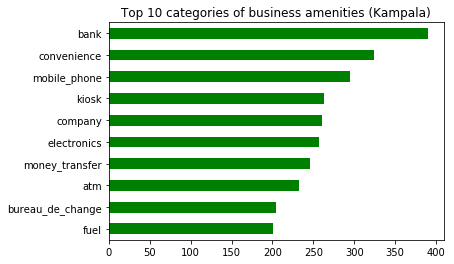

In [25]:
pois.type.value_counts()[:10].plot(kind='barh',title='Top 10 categories of business amenities (Kampala)',color='g')
plt.gca().invert_yaxis()

In [26]:
pois = gpd.GeoDataFrame(pois)
pois['geometry'] = (list(zip(pois.lon,pois.lat)))
pois['geometry'] = pois.geometry.apply(lambda x: Point(x))

#### 3. Clip raster to boundary

In [29]:
out_img, out_transform = mask(dataset=raster, shapes=boundary_JSON, crop=True)

# Update the metadata

out_meta = raster.meta.copy()
out_meta
epsg_code = int(raster.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                             )

AttributeError: module 'pycrs' has no attribute 'parse'

In [30]:
out_tif = path + '/' + 'clipped_raster.tif'

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

#### 4. Clip POIs and ES points to boundary

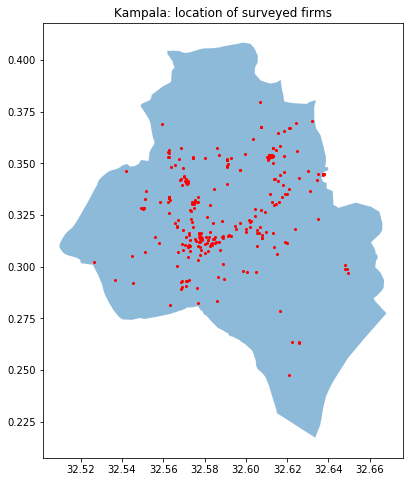

In [31]:
ax = boundary_GDF.plot(figsize=[8,8],alpha=0.5)
points_ES_clipped.plot(color='r',ax=ax,markersize=4)

plt.title('Kampala: location of surveyed firms');

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


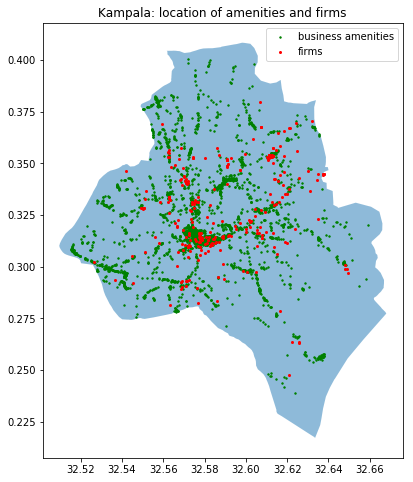

In [33]:
pois_clipped = gpd.sjoin(pois,boundary_GDF,how='inner')
points_ES_clipped = gpd.sjoin(points_ES,boundary_GDF,how='inner')

ax = boundary_GDF.plot(figsize=[8,8],alpha=0.5)
pois_clipped.plot(ax=ax, color='g',markersize=2)
points_ES_clipped.plot(color='r',ax=ax,markersize=4)

#clipped_raster = rasterio.open(out_tif)
#show(raster, ax = ax)

plt.legend(['business amenities','firms'])
plt.title('Kampala: location of amenities and firms');

In [40]:
pois_clipped.to_file('data/KM_pois/KM_biz_amenities1')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [37]:
points_ES_clipped.to_file('data/points_ES_clipped')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [38]:
pois_clipped.shape

(3307, 11)

#### 5. Get road network

In [125]:
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

## ANALYSIS
#### 6. Road network to time

In [126]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [127]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

#### 7. Snap firms and POIs to graph

In [129]:
point_df_with_nearest_node_field = gn.pandana_snap(G, points_ES_clipped)
pois_df_with_nearest_node_field = gn.pandana_snap(G, pois_clipped)
print("ES shape: {}, pois shape: {}".format(point_df_with_nearest_node_field.shape, pois_df_with_nearest_node_field.shape))

/nfshome/nj935/Kampala/GOSTnet.py:1568: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/nfshome/nj935/Kampala/GOSTnet.py:1570: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


ES shape: (307, 16), pois shape: (5321, 14)


#### 8. Map flooding onto graph

In [130]:
list_of_nearest_nodes_ES = list(point_df_with_nearest_node_field.NN)
list_of_nearest_nodes_pois = list(pois_df_with_nearest_node_field.NN)

In [131]:
importlib.reload(gn)
G = gn.sample_raster(G, out_tif, property_name = 'flood_depth')

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [132]:
G_node_gdf = gn.node_gdf_from_graph(G)

print("Flooding is positive in {:.1f}% of nodes.".format(
    (G_node_gdf[G_node_gdf.flood_depth > 0].shape[0] / G_node_gdf.shape[0])*100))

print("Flooding exceeds 15 centimeters for {:.1f}% of nodes and exceeds 40 centimeters for {:.1f}% of nodes.".format(
    ((G_node_gdf[G_node_gdf.flood_depth > 0.15].shape[0] / G_node_gdf.shape[0]*100)),
    (G_node_gdf[G_node_gdf.flood_depth > 0.4].shape[0] / G_node_gdf.shape[0])*100))

Flooding is positive in 4.1% of nodes.
Flooding exceeds 15 centimeters for 3.0% of nodes and exceeds 40 centimeters for 0.6% of nodes.


#### 9. Calculate baseline OD matrix

In [133]:
fail_value = 999999999999999
baseline_OD = gn.calculate_OD(G, list_of_nearest_nodes_ES, list_of_nearest_nodes_pois, fail_value)


In [93]:
baseline_OD_distance = gn.calculate_OD(G, list_of_nearest_nodes, list_of_nearest_nodes, fail_value, weight='length')

#### 10. Disrupt network, calculate flooded OD matrix

In [190]:
my_flood_depth = 0.15

In [191]:
importlib.reload(gn)
G_flood = G.copy()
G_flood = gn.disrupt_network(G_flood, 'flood_depth', my_flood_depth, fail_value)

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
nodes disrupted: 412
edges disrupted: 1195


In [192]:
flood_OD = gn.calculate_OD(G_flood, list_of_nearest_nodes_ES, list_of_nearest_nodes_pois, fail_value)

In [193]:
flood_OD_df = pd.DataFrame(flood_OD)

#### 11. Plot how access to amenities differs

In [194]:
baseline_OD_df = pd.DataFrame(baseline_OD)
baseline_OD_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5311,5312,5313,5314,5315,5316,5317,5318,5319,5320
0,771.15039,656.85699,143.31570,18.88836,89.10339,102.94242,291.77121,395.21757,438.91821,797.595600,...,531.514860,441.381900,445.692240,445.692240,445.358914,476.695989,1079.278380,43.62900,418.331280,503.418030
1,1112.27481,994.25010,533.23560,464.81499,342.25197,444.06684,658.49736,753.01176,796.71240,468.669210,...,315.943560,452.964420,403.657380,403.657380,370.485900,340.191630,649.227990,477.10611,450.021870,107.531889
2,877.25442,483.49980,120.31809,226.48536,305.42037,319.25940,314.59140,407.49888,451.19952,923.106771,...,330.656807,223.103319,227.038899,227.038899,226.705573,258.042647,878.113449,200.36784,200.052699,606.023289
3,1397.20899,1279.18428,818.16978,749.74917,627.18615,729.00102,943.43154,1037.94594,1081.64658,607.303950,...,600.877740,737.898600,688.591560,688.591560,655.420080,625.125810,538.802280,762.04029,734.956050,392.466069
4,985.25079,867.22608,406.21158,337.79097,215.22795,317.04282,531.47334,625.98774,669.68838,560.281140,...,326.470204,463.491064,414.184024,414.184024,381.012544,350.718274,874.233724,350.08209,460.548514,298.373374


In [232]:
minutes = 15
threshold = minutes * 60

sample_origin = baseline_OD_df.loc[101,:]
sample_origin[sample_origin > threshold].count() / sample_origin.shape[0] * 100

25.427551212178162

In [233]:
percent_reachable = baseline_OD_df[baseline_OD_df < threshold].count(axis=1) / baseline_OD_df.shape[1] * 100
percent_reachable_flood = flood_OD_df[flood_OD_df < threshold].count(axis=1) / flood_OD_df.shape[1] * 100

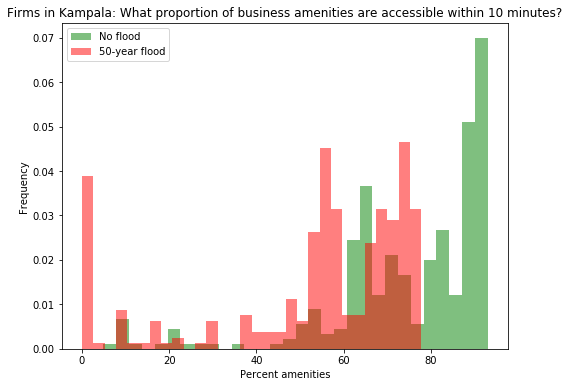

In [234]:
fig,ax = plt.subplots(figsize=[8,6])
ax.hist(percent_reachable,color='g',alpha=0.5,density=True,bins=30)
ax.hist(percent_reachable_flood,color='r',alpha=0.5,density=True,bins=30)
plt.title('Firms in Kampala: What proportion of business amenities are accessible within 10 minutes?')
plt.ylabel('Frequency')
plt.legend(['No flood','50-year flood'])
plt.xlabel('Percent amenities');

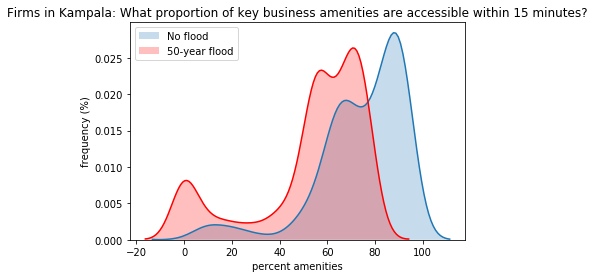

In [235]:
ax = sns.kdeplot(percent_reachable,shade=True)
sns.kdeplot(percent_reachable_flood, ax=ax, color='r',shade=True)
ax.set_title('Firms in Kampala: What proportion of key business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(['No flood','50-year flood'])
ax.set(xlabel="percent amenities", ylabel='frequency (%)');